# BE Bitcoin Heist


In [9]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope


In [40]:
# load the dataset in a pandas DataFrame
df = pd.read_csv('data/BitcoinHeistData.csv')

In [ ]:

df['y'] = (df['label'] != 'white').astype(int)
df_white = df[df['y'] == 0]
df_ransomware = df[df['y'] == 1]
print(f"il y a {len(df_white)} adresses blanches et {len(df_ransomware)} ransomwares")
print(f"proportion de ransomwares: {len(df_ransomware) / len(df)}")

il y a 2875284 adresses blanches et 41413 ransomwares
proportion de ransomwares: 0.014198595191752863


In [47]:
# base features
features = ['length','weight','count','looped','neighbors','income']
X = df[features].copy()
y = df['y'].values

# in y, 0 = clean, 1 = attack
# i want 1= clean, -1 = attack
y = np.where(y == 0, 1, -1)


In [48]:
print(y)

[-1 -1 -1 ...  1  1  1]


## Feature engineering

. Adding feature combinations
. Applying log transforms on appropriate combinations
. Normalise and center all features


### Ajout des combinaisons de colonnes

In [30]:
# Adding derived features
X['merge_efficiency'] = X['weight'] / (X['count'] + 1)
X['loop_ratio'] = X['looped'] / (X['count'] + 1)
X['mix_complexity'] = X['length'] * X['count']
X['income_per_neighbor'] = X['income'] / (X['neighbors'] + 1)
X['mix_intensity'] = (X['length'] + X['looped']) / (X['neighbors'] + 1)

# append derived features to the features list so they are included downstream
derived = ['merge_efficiency','loop_ratio','mix_complexity','income_per_neighbor','mix_intensity']
features = features + derived

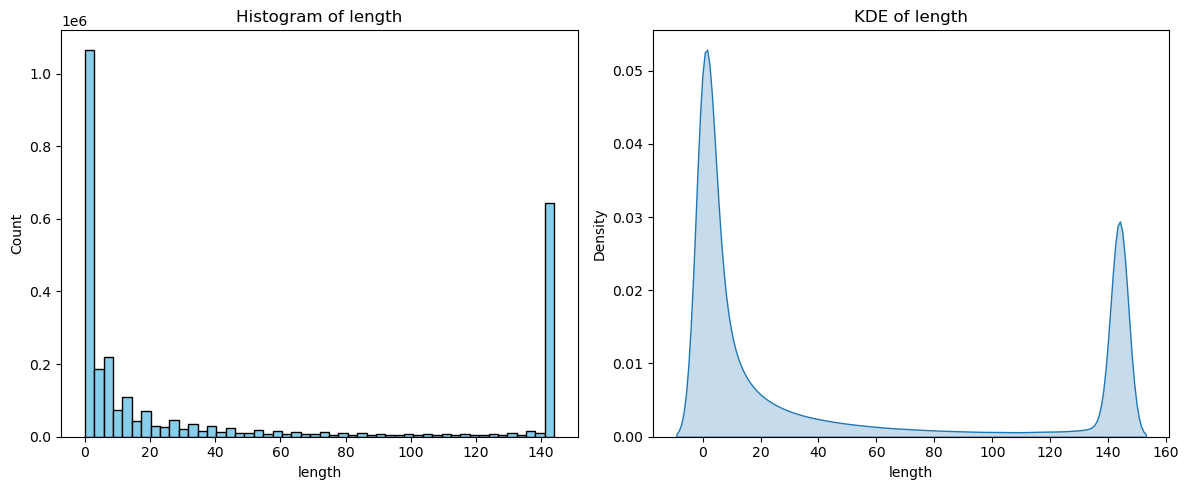

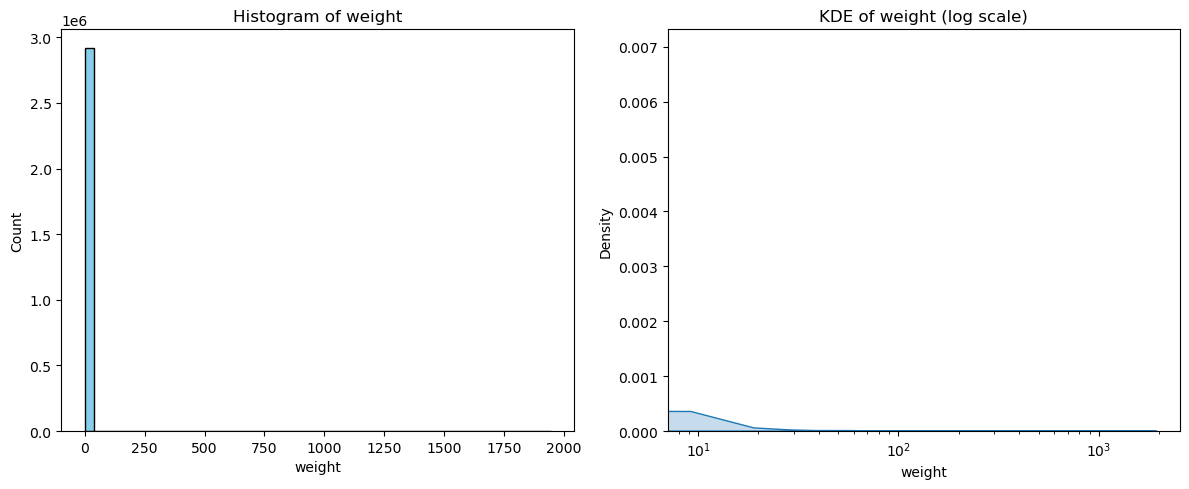

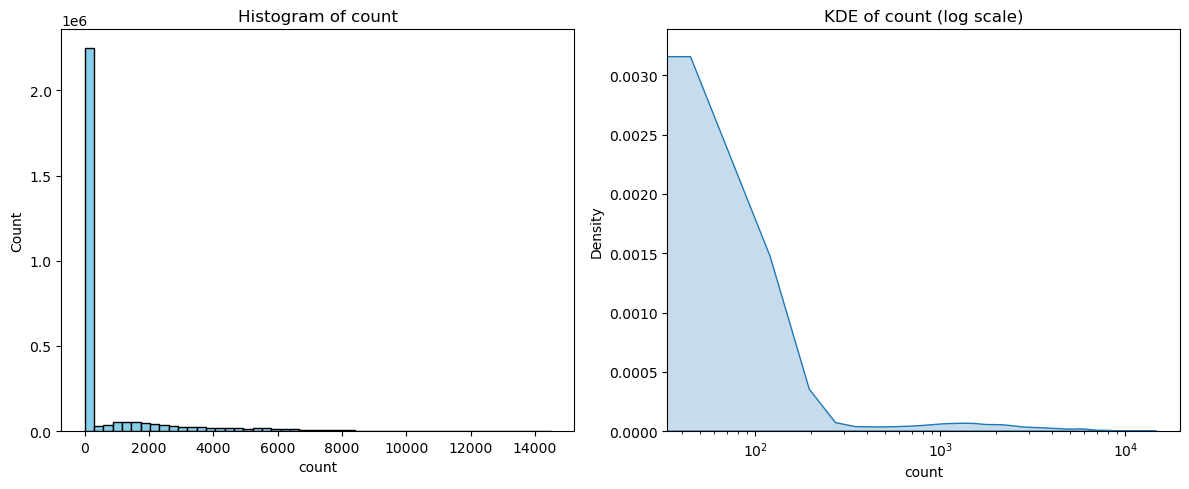

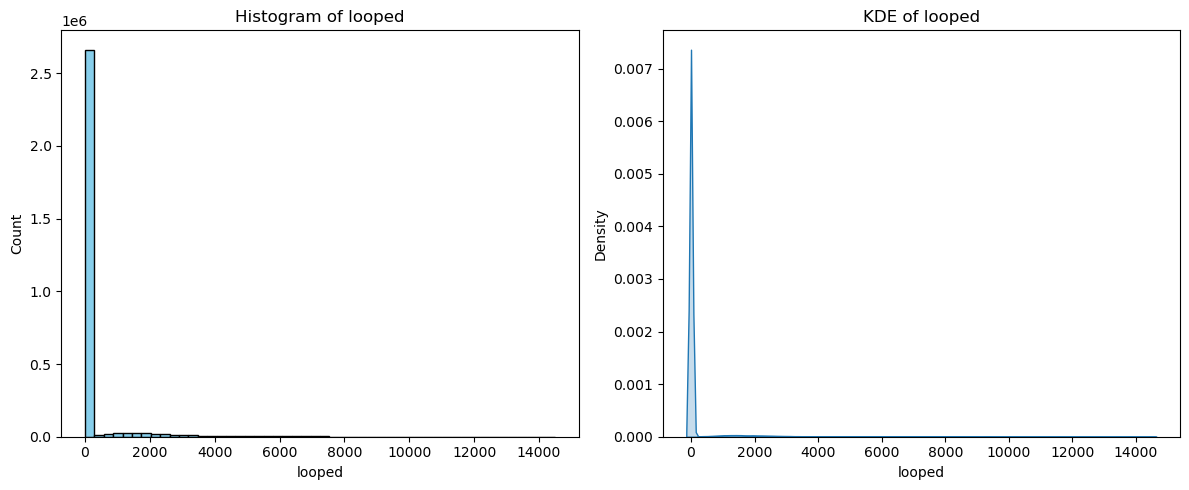

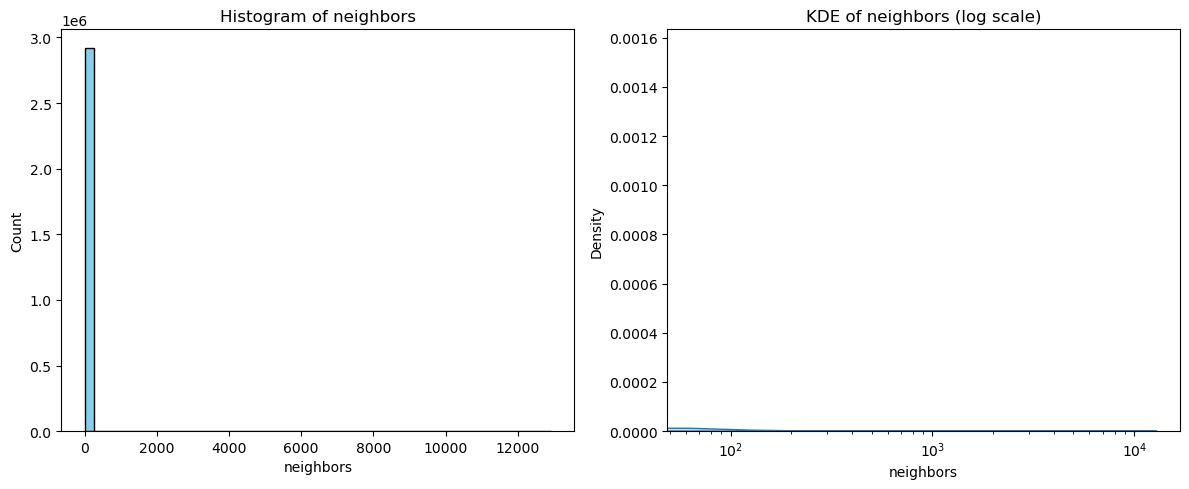

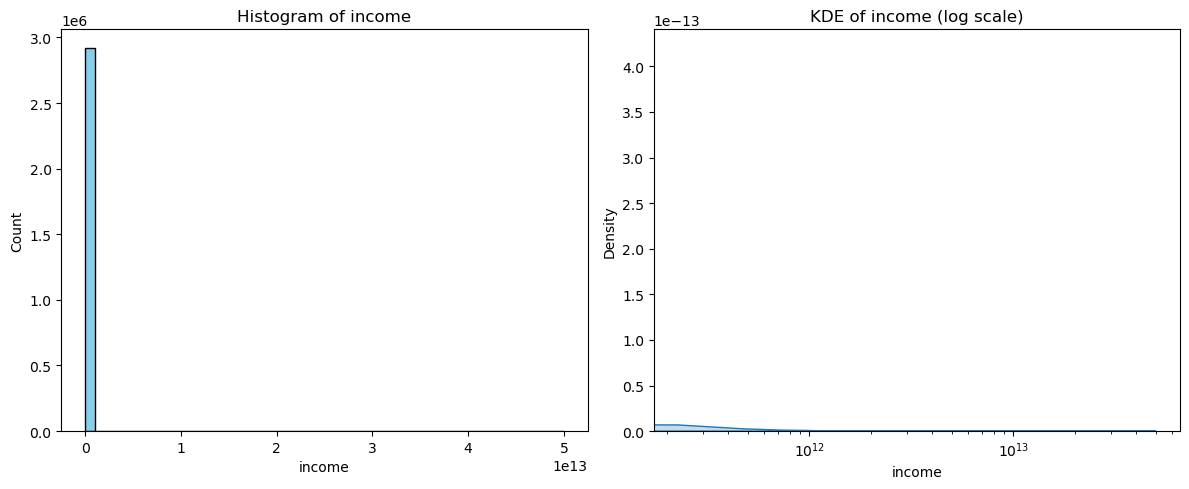

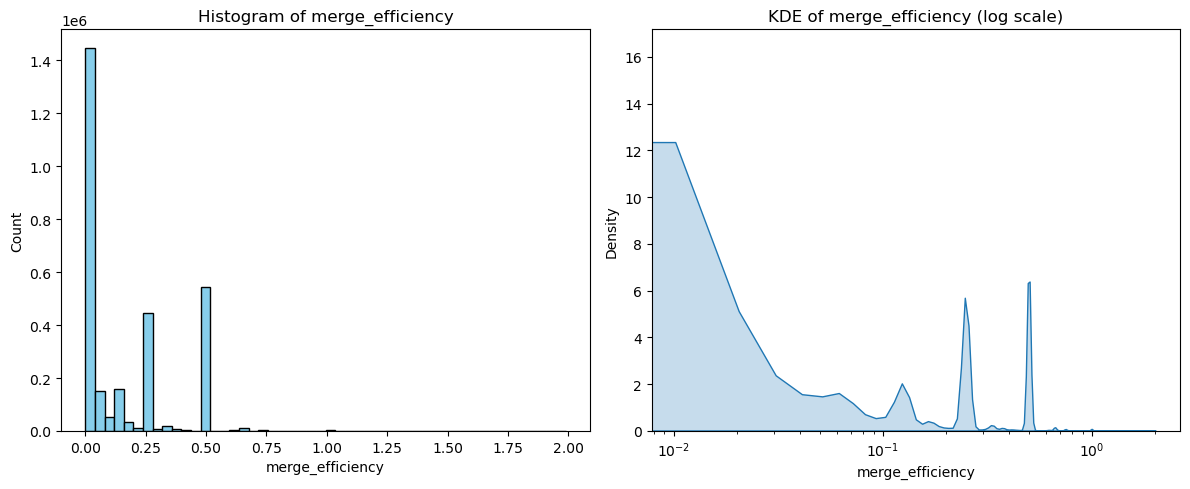

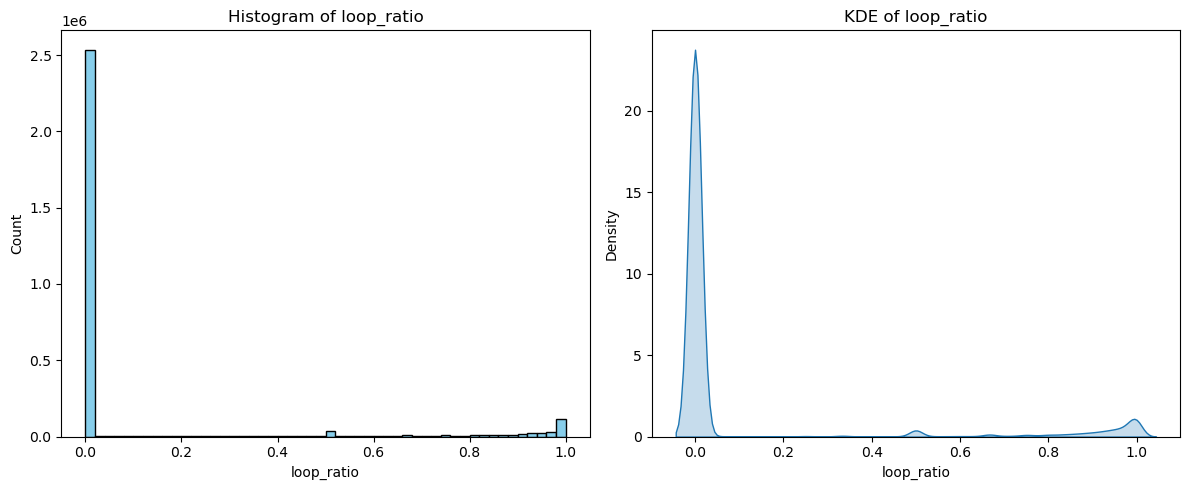

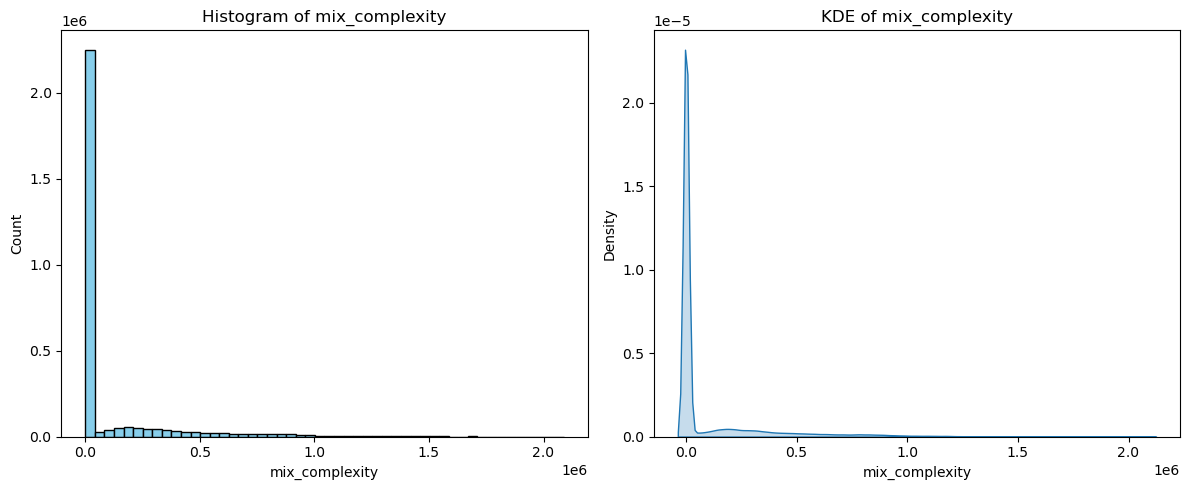

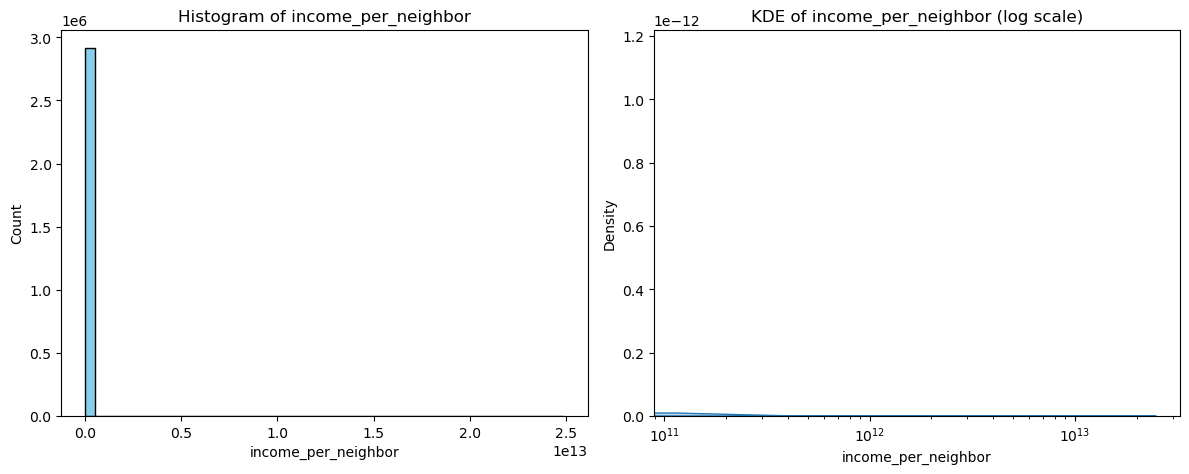

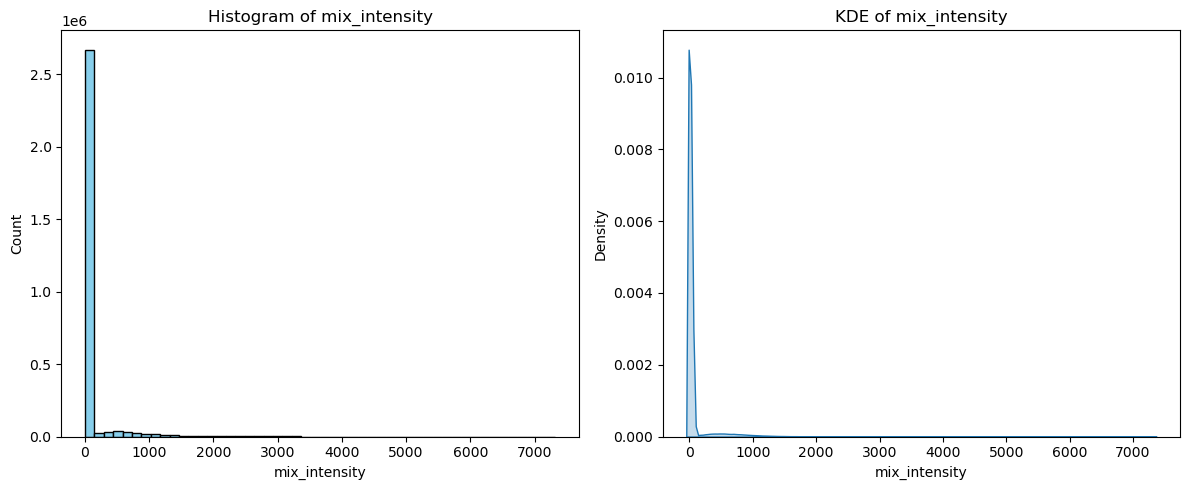

In [24]:
# Visualize right skewness for each feature
for feature in features:
    data = X[feature]
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    
    # KDE plot (log scale if all values > 0)
    plt.subplot(1, 2, 2)
    if (data > 0).all():
        sns.kdeplot(data, fill=True)
        plt.xscale('log')
        plt.title(f'KDE of {feature} (log scale)')
    else:
        sns.kdeplot(data, fill=True)
        plt.title(f'KDE of {feature}')
    plt.xlabel(feature)
    
    plt.tight_layout()
    plt.show()

Right skewness is present for all features but Length and merge efficiency
For this reason, we will pass all features to log except these two

In [31]:
# passing all features to log except Length and merge efficiency
X_log = X.copy()

for feature in features:
    if feature not in ['length', 'merge_efficiency']:
        X_log[feature] = np.log1p(X[feature])

### normalize and center features


In [34]:
# normalizing and centering features of X_log
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_log), columns=X_log.columns)


### Creating attack and clean datasets


In [49]:
# Create separate datasets for attack and clean samples
X_attack = X_scaled[features][y == -1].copy()
y_attack = y[y == -1].copy()
X_clean = X_scaled[features][y == 1].copy()
y_clean = y[y == 1].copy()


In [55]:
# Sample 80% for training, 20% for testing
X_attack_train = X_attack.sample(frac=0.8, random_state=42)
X_clean_train = X_clean.sample(frac=0.8, random_state=42)

train_indices = X_attack_train.index.append(X_clean_train.index)
test_indices = X_scaled.index.difference(train_indices)

X_train = X_scaled.loc[train_indices]
X_test = X_scaled.loc[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]


## training a isolation forest model

In [56]:
# training a isolation forest model
iso_forest = IsolationForest( n_estimators=1000 ,contamination=0.05, random_state=42)
iso_forest.fit(X_train)
y_pred = iso_forest.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.02      0.06      0.03      8283
           1       0.99      0.95      0.97    575057

    accuracy                           0.94    583340
   macro avg       0.50      0.51      0.50    583340
weighted avg       0.97      0.94      0.95    583340

[[   507   7776]
 [ 28698 546359]]
